In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32 # NUMBER OF IMAGES TP LOAD EACH TIME
CHANNELS = 3 
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
shuffle = True,
image_size = (IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

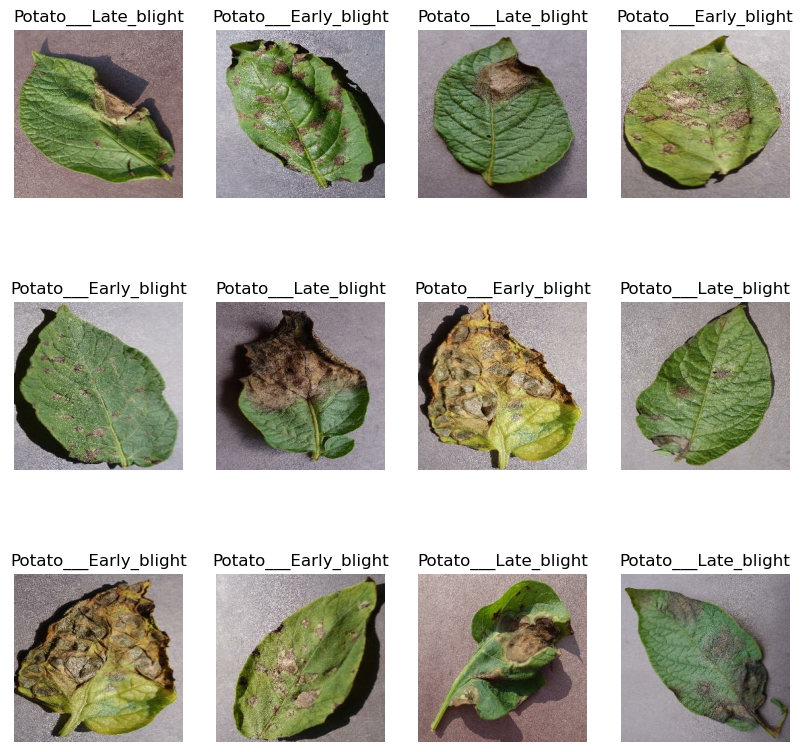

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
    # print(image_batch[0].shape)
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

80% ==> training
20% ==> 10% validation, 10% test

In [7]:
def partition_dataset_tf( ds, train_split =0.8,
                        val_split = 0.1,
                        test_split = 0.1,
                        shuffle= True,
                        shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds , test_ds

In [8]:
train_ds, val_ds, test_ds = partition_dataset_tf(dataset)

Cache, Shuffle, and Prefetch the Dataset

In [9]:
# calling images to cache memory for easier access if gpu is busy prefetch gets the 
# images from your memory and improves the performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model
first resize the pics to have value btween 0,1 by normalizing the ize to 256. 

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data. It rotates, flips, chnage different aspects ofeach image to have multiple reincarnation of each image for increased accuracy

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Building

In [13]:
# use a CNN coupled with a Softmax activation in the output layer.
# add the initial layers for resizing, normalization and Data Augmentation.
# relu is fast and god for image processing
# the 32, 64 and etc are filter size and the larger it is, it will detect edges better
# we use max pooling whcih find max value of each sub array in the image to reduce the size and save max value of the features
# softmax normalizes probality of classes
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# compile the model

In [15]:
# We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
# record history so we can plot and see how things work
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs= EPOCHS,
)

Epoch 1/50


54/54 [==============================] - 30s 523ms/step - loss: 0.8711 - accuracy: 0.5150 - val_loss: 0.6908 - val_accuracy: 0.7083
Epoch 2/50
54/54 [==============================] - 29s 534ms/step - loss: 0.5917 - accuracy: 0.7350 - val_loss: 0.4184 - val_accuracy: 0.8125
Epoch 3/50
54/54 [==============================] - 29s 531ms/step - loss: 0.3905 - accuracy: 0.8397 - val_loss: 0.2101 - val_accuracy: 0.9115
Epoch 4/50
54/54 [==============================] - 30s 548ms/step - loss: 0.3146 - accuracy: 0.8744 - val_loss: 0.2014 - val_accuracy: 0.9271
Epoch 5/50
54/54 [==============================] - 27s 502ms/step - loss: 0.2564 - accuracy: 0.9005 - val_loss: 0.2561 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 28s 521ms/step - loss: 0.2492 - accuracy: 0.9028 - val_loss: 0.5373 - val_accuracy: 0.7656
Epoch 7/50
54/54 [==============================] - 28s 518ms/step - loss: 0.2057 - accuracy: 0.9178 - val_loss: 0.3860 - val_accuracy: 0.84

In [17]:
scores = model.evaluate(test_ds)
# scores

8/8 [==============================] - 2s 123ms/step - loss: 0.1119 - accuracy: 0.9688


In [18]:
# Plotting the Accuracy and Loss Curves
history

In [19]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [20]:
#lists containing values of loss, accuracy etc
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
type(history.history['loss'])

list

In [22]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8710744380950928,
 0.5916597843170166,
 0.39054664969444275,
 0.31457269191741943,
 0.2563832104206085]

In [23]:
# store history in separate variables

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


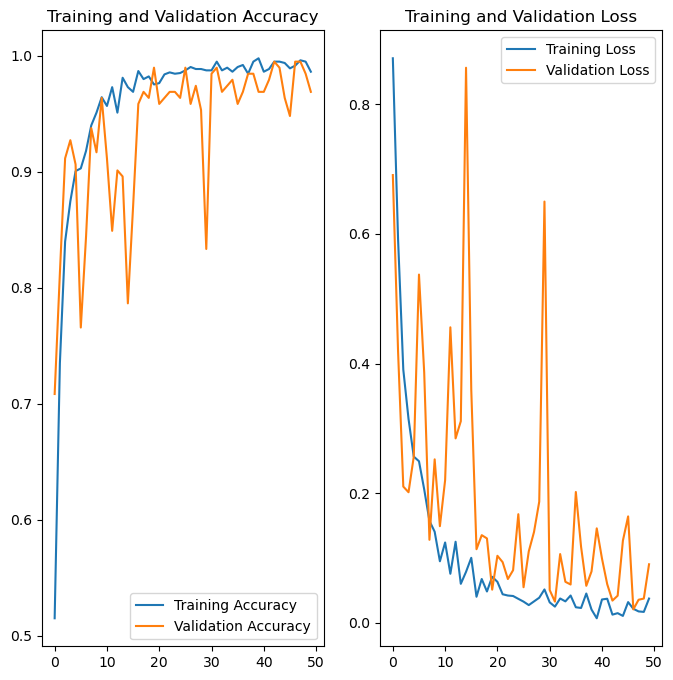

In [24]:
# plot loss annd accuracy 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Potato___healthy
1/1 [==============================] - 0s 281ms/step
predicted label: Potato___healthy


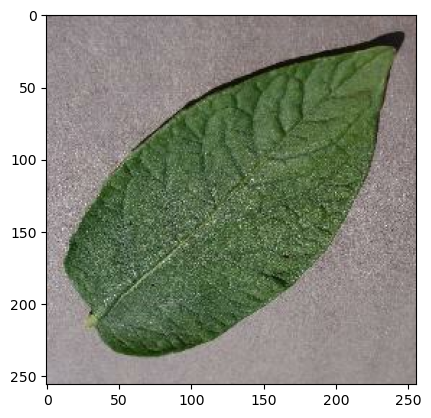

In [25]:
# Run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [26]:
# function for inference shows the confidence for a predicted class
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


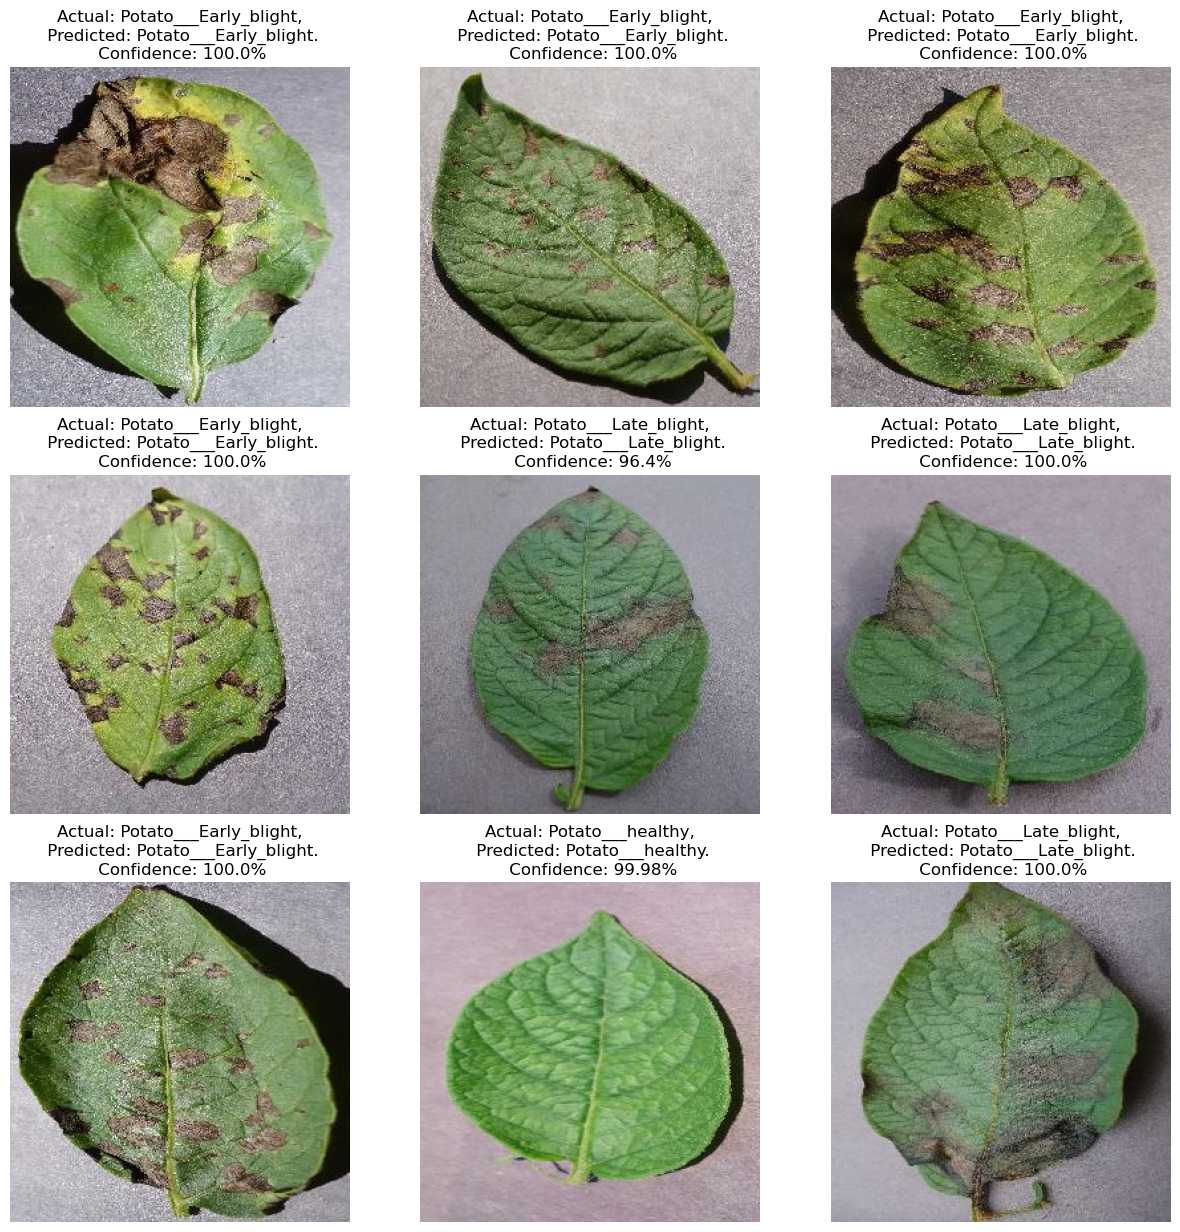

In [27]:
# run inference on few sample images

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model
 We append the model to the list of models as a new version

In [31]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [32]:
model.save("../potatoes.h5")

C:\Users\laleh\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
